In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import math
from scipy.fftpack import fft
import scipy.signal as sig
from scipy.signal import stft
import matplotlib.mlab as mlab
from scipy import signal

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# data = pd.read_csv('drive/MyDrive/Neurointerfaces/OpenBCI-RAW-2021-03-03_10-33-51.txt', skiprows=4, header=0, delimiter=',')

Считываем данные наших измерений

In [ ]:
data = pd.read_csv('https://drive.google.com/uc?export=download&id=1RZErRbwOzTcd6_JJ3mYLuGcwlpjoJU_R', skiprows=4, header=0, delimiter=',')

Функция для считывания сигнала с определенного канала и преобразования времени из формата Timestamp в секунды.
Функции для рисовки любого графика и кубическая интерполяция(вспомогательные функции).

In [ ]:
def getTimeAndSignal2(data, channel):
  data_time = []
  for i in range(len(data[' Timestamp (Formatted)'])):
    data_time.append(int(data[' Timestamp (Formatted)'][i][-9:-7]) * 60 + int(data[' Timestamp (Formatted)'][i][-6:-4]) + int(data[' Timestamp (Formatted)'][i][-3:]) / 1000 -
                             (int(data[' Timestamp (Formatted)'][0][-9:-7]) * 60 + int(data[' Timestamp (Formatted)'][0][-6:-4]) + int(data[' Timestamp (Formatted)'][0][-3:]) / 1000))
  return data_time, data[' EXG Channel {}'.format(channel)]

def getPlot(time, signal, description=['Title', 'Time', 'Signal'], grid=False):
  plt.figure(figsize=(70, 16))
  plt.plot(time, signal, color = 'blue')
  plt.ylim(min(signal), max(signal))
  plt.title(description[0])
  plt.xlabel(description[1])
  plt.ylabel(description[2])
  plt.grid(grid)
  plt.show()

fd = 125
def cubicInterpolating(time, signal):
  time = range(len(signal))
  cubic_interpolating = CubicSpline(time, signal)
  data_time_interpolated = []
  data_signal_interpolated = []
  for i in np.arange(0, math.floor(max(time)), 1/fd):
    data_time_interpolated.append(i)
    data_signal_interpolated.append(cubic_interpolating(i))
  return data_time_interpolated, data_signal_interpolated

Как выглядит график необработанного сигнала из первого канала.

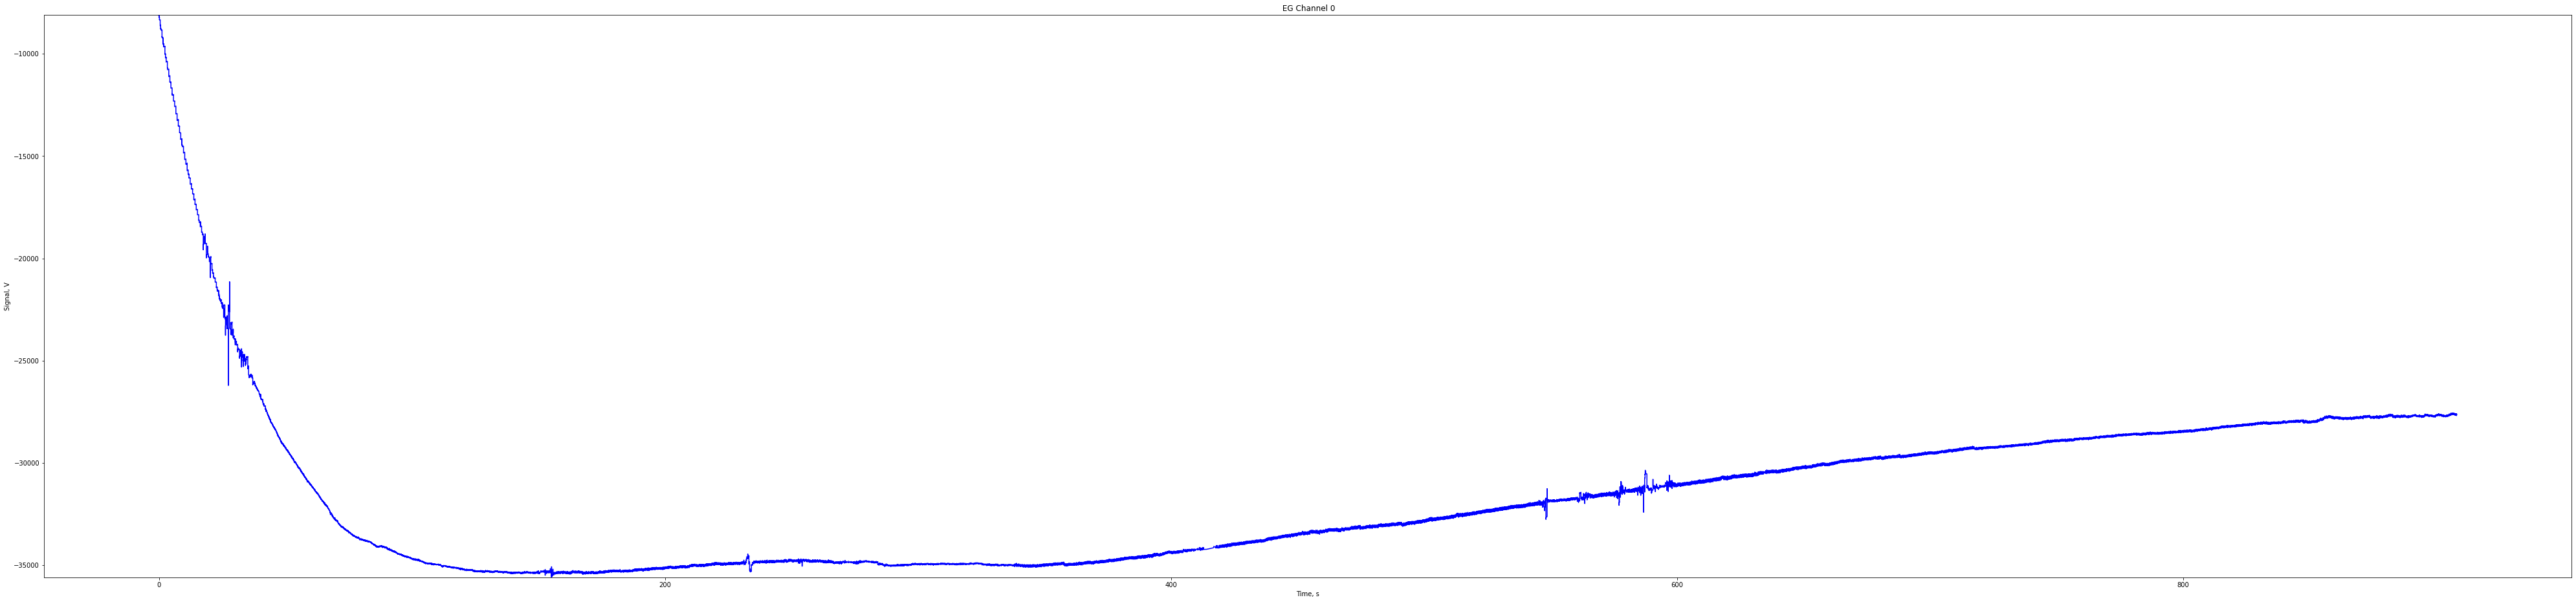

In [ ]:
time, new_signal = getTimeAndSignal2(data, 2)

getPlot(time, new_signal, [' EG Channel 0', 'Time, s', 'Signal, V'])

Все основные функции, которые помогают проанлизировать исходный сигнал и найти его характеристики (например, спектр).

In [ ]:
dict_rhythms = {'Delta': [0.5, 4], 'Theta': [4, 8], 'Alfa': [8, 13], 'Beta': [13, 32], 'Gamma': [32, 60]}
hp_cutoff_Hz = 1.0
fs_Hz = 125.0

def refactor_signal_and_plot(data, eg_channel, plotted=True):
  time, new_signal = getTimeAndSignal2(data, channel=eg_channel)

  b, a = signal.butter(2, hp_cutoff_Hz/(fs_Hz / 2.0), 'highpass')
  new_signal = signal.lfilter(b, a, new_signal, 0)

  notch_freq_Hz = np.array([50.0])  # main + harmonic frequencies
  for freq_Hz in np.nditer(notch_freq_Hz):  # loop over each target freq
    bp_stop_Hz = freq_Hz + 3.0*np.array([-1, 1])  # set the stop band
    b, a = signal.butter(3, bp_stop_Hz/(fs_Hz / 2.0), 'bandstop')
    new_signal = signal.lfilter(b, a, new_signal, 0)
    # print("Notch filter removing: " + str(bp_stop_Hz[0]) + "-" + str(bp_stop_Hz[1]) + " Hz")

  t_sec = np.arange(len(new_signal))
  if plotted:
    print("Generating signal plot...")
    plt.figure(figsize=(10,5))
    plt.subplot(1,1,1)
    plt.plot(t_sec, new_signal)
    plt.xlabel('Time (sec)')
    plt.ylabel('Power (uV)')
    plt.title('Channel {}'.format(eg_channel + 1))
    plt.show()

  return new_signal


NFFT = 512
overlap = NFFT - int(0.25 * fs_Hz)

def get_spectrogram_and_plot(new_signal, plotted=True):

  spec_PSDperHz, spec_freqs, spec_t = mlab.specgram(np.squeeze(new_signal),
                                                    NFFT=NFFT,
                                                    window=mlab.window_hanning,
                                                    Fs=fs_Hz,
                                                    noverlap=overlap
                                                    ) # returns PSD power per Hz
  # convert the units of the spectral data
  spec_PSDperBin = spec_PSDperHz * fs_Hz / float(NFFT)


  start = 1
  stop = 50

  bp_Hz = np.zeros(0)
  bp_Hz = np.array([start,stop])
  b, a = signal.butter(3, bp_Hz/(fs_Hz / 2.0),'bandpass')
  new_signal = signal.lfilter(b, a, new_signal, 0)

  if plotted:
    print("Spectrum data...")
    print("Bandpass filtering to: " + str(bp_Hz[0]) + "-" + str(bp_Hz[1]) + " Hz")
    print("Generating spectrogram...")
    f_lim_Hz = [0, 50]   # frequency limits for plotting
    plt.figure(figsize=(10,5))
    ax = plt.subplot(1,1,1)
    plt.pcolor(spec_t, spec_freqs, 10*np.log10(spec_PSDperBin))  # dB re: 1 uV
    plt.clim([-25,26])
    plt.xlim(spec_t[0], spec_t[-1]+1)
    plt.ylim(f_lim_Hz)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram')

    ax.text(0.025, 0.95,
            "NFFT = " + str(NFFT) + "\nfs = " + str(int(fs_Hz)) + " Hz",
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            backgroundcolor='w'
            )
    plt.show()

  return spec_freqs, spec_PSDperHz, spec_PSDperBin, spec_t


def plot_band_power(spec_PSDperBin, spec_t, spec_freqs, band_name='Delta'):
  start_freq, end_freq = dict_rhythms[band_name]

  print("Plotting band power over time. Frequency range: "+str(start_freq)+" - "+str(end_freq))
  bool_inds = (spec_freqs > start_freq) & (spec_freqs < end_freq)
  band_power = np.sqrt(np.amax(spec_PSDperBin[bool_inds, :], 0))
  plt.figure(figsize=(10,5))
  plt.plot(spec_t,band_power)
  plt.ylim([np.amin(band_power), np.amax(band_power)+1])
  plt.xlabel('Time (sec)')
  plt.ylabel('EEG Amplitude (uVrms)')
  plt.title('Trend Graph of '+band_name+' EEG Amplitude over Time')
  plt.grid(True)
  plt.show()

def plot_spectrum_avg_fft(new_signal, spec_PSDperHz, eg_channel, spec_freqs, band_name='Delta'):
  start_freq, end_freq = dict_rhythms[band_name]
  spectrum_PSDperHz = np.mean(spec_PSDperHz,1)

  t = 811
  N = 101396 # t * fs_Hz

  freq = np.fft.fftfreq(N, 1/fs_Hz)
  freq_rhythm = freq[int(start_freq*t):int(end_freq*t)]

  fft_signal = np.fft.fft(new_signal)
  fft_signal_rhythm = fft_signal[int(start_freq*t):int(end_freq*t)]
  signal_rhythm = np.fft.ifft(fft_signal_rhythm)

  # print("Power spectrum plot")
  plt.figure(figsize=(20,8))

  plt.subplot(1, 2, 1)
  plt.plot(freq_rhythm, np.abs(signal_rhythm), color = "blue", label = "Signal")
  plt.xlabel("Frequency, Hz")
  plt.ylabel("Signal, V")
  plt.legend(ncol=1)
  plt.title("Signal and Frequency")
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.plot(spec_freqs, 10*np.log10(spectrum_PSDperHz))  # dB re: 1 uV
  # plt.axvline(x = start_freq, color = 'r')
  # plt.axvline(x = end_freq, color = 'r')
  plt.axvspan(xmin=start_freq, xmax=end_freq, alpha=0.5, color='red')
  plt.xlim((0,60))
  plt.ylim((-30,50))
  plotname = 'Channel '+str(eg_channel + 1)+' Spectrum Average FFT Plot' #channel 0
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('PSD per Hz (dB re: 1uV^2/Hz)')
  plt.title("Power Spectrum")
  plt.grid(True)

  plt.tight_layout()
  plt.show()

Блок для вывод результатов, выполнен в виде несложного GUI.

In [ ]:
import ipywidgets as widgets
# from google.colab import widgets
from IPython.display import display
%matplotlib inline

output = widgets.Output()

actions=['Draw a signal graph', 'Display spectrogram', 'Amplitude plot', 'Display power spectrum', 'All']
rhythms = ['Delta', 'Theta', 'Alfa', 'Beta', 'Gamma']
bounded_channel_number = widgets.BoundedIntText(value=1, min=1, max=16, step=1, description='Channel:')
dropdown_action = widgets.Dropdown(options=actions, description='Action:')
dropdown_rhythm = widgets.Dropdown(options=rhythms, description='Rhythm: ')

def common_filtering(num, action, rhythm='Delta'):
  output.clear_output()

  with output:
    if action == 'Draw a signal graph':
      refactor_signal_and_plot(data, eg_channel=num)
    elif action == 'Display spectrogram':
      new_signal = refactor_signal_and_plot(data, eg_channel=num, plotted=False)
      get_spectrogram_and_plot(new_signal)
    elif action == 'Amplitude plot':
      display(dropdown_rhythm)
      new_signal = refactor_signal_and_plot(data, eg_channel=num, plotted=False)
      spec_freqs, spec_PSDperHz, spec_PSDperBin, spec_t = get_spectrogram_and_plot(new_signal, plotted=False)
      plot_band_power(spec_PSDperBin, spec_t, spec_freqs, band_name=rhythm)
    elif action == 'Display power spectrum':
      display(dropdown_rhythm)
      new_signal = refactor_signal_and_plot(data, eg_channel=num, plotted=False)
      spec_freqs, spec_PSDperHz, spec_PSDperBin, spec_t = get_spectrogram_and_plot(new_signal, plotted=False)
      plot_spectrum_avg_fft(new_signal, spec_PSDperHz, num, spec_freqs, band_name=rhythm)
    elif action == 'All':
      display(dropdown_rhythm)
      new_signal = refactor_signal_and_plot(data, eg_channel=num)
      spec_freqs, spec_PSDperHz, spec_PSDperBin, spec_t = get_spectrogram_and_plot(new_signal)
      plot_band_power(spec_PSDperBin, spec_t, spec_freqs, band_name=rhythm)
      plot_spectrum_avg_fft(new_signal, spec_PSDperHz, num, spec_freqs, band_name=rhythm)

def bounded_channel_number_eventhandler(change):
  common_filtering(change.new - 1, dropdown_action.value, dropdown_rhythm.value)

def dropdown_action_eventhandler(change):
  common_filtering(bounded_channel_number.value - 1, change.new, dropdown_rhythm.value)

def dropdown_rhythm_eventhandler(change):
  common_filtering(bounded_channel_number.value - 1, dropdown_action.value, change.new)

bounded_channel_number.observe(bounded_channel_number_eventhandler, names='value')
dropdown_action.observe(dropdown_action_eventhandler, names='value')
dropdown_rhythm.observe(dropdown_rhythm_eventhandler, names='value')

display(bounded_channel_number)
display(dropdown_action)

display(output)

BoundedIntText(value=1, description='Channel:', max=16, min=1)

Dropdown(description='Action:', options=('Draw a signal graph', 'Display spectrogram', 'Amplitude plot', 'Disp…

Output()

> Дельта-ритм (0.5-4 Гц)

Возникает при глубоком естественном сне

> Тета-ритм (4-8 Гц)

Возникает при глубоком расслаблении, занятии творчеством.

> Альфа-ритм (8-13 Гц)

Наибольшую амплитуду альфа-ритм имеет в состоянии спокойного расслабленного бодрствования, особенно при закрытых глазах в затемненном помещении.

> Бета-ритм (13-32 Гц)

Бета-ритм регистрируется в области передних и центральных извилин. Распространяется на задние центральные и лобные извилины. Бета-волны в норме связаны с высшими когнитивными процессами и фокусированием внимания, в обычном бодрствующем состоянии, когда мы с открытыми глазами наблюдаем за происходящими событиями, или сосредоточены на решении каких-либо текущих проблем.

> Гамма-ритм (32-100 Гц)

Гамма-ритм наблюдается при решении задач, требующих максимального сосредоточенного внимания.
